In [1]:
import pandas as pd
import csv
import pickle as pkl
import numpy as np
from fasttext import FastText
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime


In [2]:
model = FastText.load_model('cc.en.300.bin')

In [3]:
class Embeddings:
    def __init__(self, model) -> None:
        self.model = model
    def get_embeddings(self, words):
        return np.array([self.model.get_word_vector(i) for i in words])
    

In [4]:
tags = pkl.load(open('./tags.pkl', 'rb'))

In [5]:
embedding_class = Embeddings(model)
ems = embedding_class.get_embeddings(tags[:100])

In [6]:
anew_dataset = pd.read_csv('./anew.csv')

In [7]:
anew_dict= dict()
words = anew_dataset['term']
valence_ratings = anew_dataset['pleasure']
arousal_ratings = anew_dataset['arousal']
word_embeddings = embedding_class.get_embeddings(words)
word_embedding_dict = dict(zip(words, word_embeddings))
for i in range(len(words)):
    anew_dict[words[i]] = [valence_ratings[i], arousal_ratings[i]]

In [8]:
X = word_embeddings
Y = np.array([anew_dict[i] for i in words])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [11]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
test_dataset = TensorDataset(X_test, y_test)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [13]:
device

'cpu'

In [20]:
class NetworkModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(300, 150)
        self.linear_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(150, 100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(25, 10),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.Dropout(0.3),
            nn.ReLU(),
        )
        self.output = nn.Linear(5, 2)

    def forward(self, x):
        x = self.input(x)
        x = self.linear_stack(x)
        x = self.output(x)
        return x



In [22]:
model_train = NetworkModel().to(device)
epochs = 10000
learning_rate = 0.000001
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_train.parameters(), lr=learning_rate, weight_decay=0.001)
test_loss = []
train_loss = []
for i in range(epochs):
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        Y_pred = model_train(X.float())
        loss = loss_fn(Y_pred, Y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {i}, Training Loss: {loss.item()}')
    train_loss.append(loss.item())
    # Test Loss
    with torch.no_grad():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            Y_pred = model_train(X.float())
            test_loss_fn = loss_fn(Y_pred, Y.float())
        print(f'Epoch {i}, Test Loss: {test_loss_fn.item()}')
        test_loss.append(test_loss_fn.item())

Epoch 0, Training Loss: 3765.1357421875
Epoch 0, Test Loss: 3312.1669921875
Epoch 1, Training Loss: 3880.074462890625
Epoch 1, Test Loss: 3978.86669921875
Epoch 2, Training Loss: 3595.643798828125
Epoch 2, Test Loss: 4379.77783203125
Epoch 3, Training Loss: 3955.01025390625
Epoch 3, Test Loss: 3204.2265625
Epoch 4, Training Loss: 3435.1240234375
Epoch 4, Test Loss: 3528.4912109375
Epoch 5, Training Loss: 3755.8310546875
Epoch 5, Test Loss: 4237.89111328125
Epoch 6, Training Loss: 4704.92919921875
Epoch 6, Test Loss: 4006.56298828125
Epoch 7, Training Loss: 4328.81689453125
Epoch 7, Test Loss: 3563.090576171875
Epoch 8, Training Loss: 3053.95166015625
Epoch 8, Test Loss: 3937.635986328125
Epoch 9, Training Loss: 3268.282958984375
Epoch 9, Test Loss: 4353.37744140625
Epoch 10, Training Loss: 3844.43603515625
Epoch 10, Test Loss: 3695.929931640625
Epoch 11, Training Loss: 3966.73291015625
Epoch 11, Test Loss: 4168.84521484375
Epoch 12, Training Loss: 3526.5
Epoch 12, Test Loss: 4145.23144

KeyboardInterrupt: 

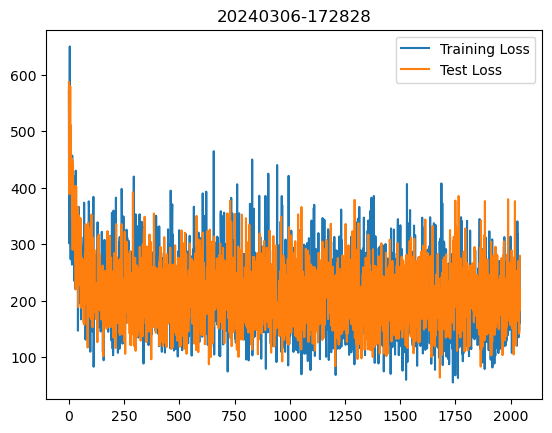

In [18]:
plt.plot(train_loss[1000:], label='Training Loss')
plt.plot(test_loss[1000:], label='Test Loss')
plt.legend()
datestring = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.title(datestring)
plt.savefig(f'./train_logs/{datestring}.png')

<Figure size 640x480 with 0 Axes>